<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src/tl-generic/Spectrogram_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import json
import joblib
import librosa
import datetime

import numpy as np
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy.signal import spectrogram
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

tf.random.set_seed(42)

tf.__version__

'2.4.1'

In [2]:
CONFIG = {
    'timestamp'             : str(datetime.datetime.now()),
    'model'                 : 'Transfer Learning on MobileNet',
    'base_model'            : 'mobile_net_v2',
    'input_shape'           : (160, 160, 3),
    'test_fold'             : 'Fold 5',
    'frame_length'          : 44100,
    'frame_inc'             : 11025,
    'fig_size'              : (2.23, 2.23), # 160x160
    'architecture'          : '',
    'batch_size'            : 32,
    'epochs'                : 300,
    'learning_rate'         : 0.0001,
    'monitor'               : 'val_loss',
    'patience'              : 10,
    'class_weight'          : { 0: 0.71, 1:  2.32, 2: 0.86 },
    'training_time'         : 0,
    'testing_time'          : 0,
    'cm_atick'              : '',
    'cr_atick'              : '',
    'cm_valentina'          : '',
    'cr_valentina'          : ''
}

In [3]:
BASE_DIR            = os.getcwd()
LOG_FILE            = '/content/drive/MyDrive/Research/Crowd Emotion Logs/tl_generic.txt'
FOLDS               = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
EMOTIONS            = ['Approval', 'Disapproval', 'Neutral']

ATICK_DATA_DIR      = '/content/Dataset-Atick/'
VALENTINA_DATA_DIR  = '/content/Dataset-Valentina/'

RANGE               = [20, 20000]

ATICK_DATASET_LEN   = 13806
VAL_DATASET_LEN     = 9484

In [4]:
%%time

# # ----------------- Loading my dataset -------------------
# !mkdir /content/Dataset-Atick/
# !gdown --id '1zGfANn9GKi9OUMbMehkfzk_Pvhc-b68N'
# !tar -xf /content/Atick_CE_Dataset.tar.xz -C /content/Dataset-Atick/

# # ----------------- Loading Valentina's dataset -------------------
# !mkdir /content/Dataset-Valentina/
# !gdown --id '11tC2Nmie9v3ljo60oQJ3sN1rVkorV-N1'
# !tar -xf /content/Valentina_CE_Dataset.tar.xz -C /content/Dataset-Valentina/


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


In [5]:
def generate_dataset(data_len, data_dir):
    X = np.zeros((data_len, 160, 160, 3), dtype=np.uint8)
    y = np.zeros((data_len, 1), dtype=np.uint8)
    f = np.zeros((data_len, ), dtype=np.uint8)

    count = 0

    for emotion in EMOTIONS:
        emo_path = os.path.join(BASE_DIR, data_dir, emotion)

        print('processing data for ' + emotion + ' ... ')

        for fold in ['']:
            fold_path = os.path.join(emo_path, fold)
            files = os.listdir(fold_path)

            print('processing data for ' + fold, end=' ... ')
            
            for filename in files:
                wav, sr = librosa.load(
                    path            = os.path.join(fold_path, filename),
                    sr              = 44100,
                    mono            = True
                )
                # wav, sr = sf.read(os.path.join(fold_path, filename))
                n = len(wav)
                idx = 0
                while idx < (n - CONFIG['frame_length']):
                    frame = wav[idx:(idx + CONFIG['frame_length'])]
                    idx = idx + CONFIG['frame_inc']

                    fig = Figure(figsize=CONFIG['fig_size'])
                    canvas = FigureCanvas(fig)
                    ax = fig.gca()

                    ax.axis('off')
                    fig.tight_layout(pad=0)
                    ax.margins(0)

                    ax.specgram(
                        x               = frame,
                        Fs              = 44100,
                        window          = np.hamming(400),
                        NFFT            = 400,
                        cmap            = 'jet',
                        noverlap        = 200,
                        mode            = 'psd',
                        scale           = 'dB',
                        detrend         = None,
                        scale_by_freq   = True,
                        vmin            = -160,
                        vmax            = -25,
                        interpolation   = 'hamming'      
                    )
                    ax.set_yscale('symlog')
                    ax.set_ylim(RANGE)

                    fig.canvas.draw()
                    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                    X[count, :] = img
                    y[count, 0] = EMOTIONS.index(emotion)
                    # f[count] = FOLDS.index(fold)

                    count = count + 1

            print('√')

    return X, y, f

In [6]:
# %%time
# X_VAL, y_VAL, f_VAL = generate_dataset(VAL_DATASET_LEN, VALENTINA_DATA_DIR)
# joblib.dump(X_VAL, '/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/X_VAL.joblib')
# joblib.dump(y_VAL, '/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/y_VAL.joblib')
# joblib.dump(f_VAL, '/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/f_VAL.joblib')

In [7]:
class TransferLearning():
    def __init__(self, config):

        self.base_model = config['base_model']
        self.input_shape = config['input_shape']
        self.learning_rate = config['learning_rate']
        self.batch_size = config['batch_size']
        self.epochs = config['epochs']
        self.monitor = config['monitor']
        self.patience = config['patience']
        self.class_weight = config['class_weight']

        if self.base_model == 'mobile_net_v2':
            self.base_model = tf.keras.applications.MobileNetV2(
                input_shape     = self.input_shape,
                include_top     = False,
                weights         = 'imagenet'
            )
            self.base_model.trainable = False
            self.preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
            self.model = None
            self.callbacks = None

    def __init_model(self, num_classes):
        inputs = tf.keras.Input(shape=self.input_shape)
        x = self.preprocess(inputs)
        x = self.base_model(x, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(num_classes)(x)
        self.model = tf.keras.Model(inputs, outputs)
        self.model.compile(
            optimizer      = tf.keras.optimizers.Adam(lr=self.learning_rate),
            loss           = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics        = ['accuracy']
        )

    def __init_callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor        = self.monitor,
            patience       = self.patience,
            verbose        = 1
        )
        self.callbacks = [
                          early_stopping,
        ]

    def fit(self, train_X, train_y, val_X, val_y):
        num_classes = np.unique(train_y).shape[0]
        self.__init_model(num_classes)
        self.__init_callbacks()
        history = self.model.fit(
            x                 = train_X,
            y                 = train_y,
            batch_size        = self.batch_size,
            epochs            = self.epochs,
            verbose           = 1,
            validation_data   = (val_X, val_y),
            shuffle           = True,
            callbacks         = self.callbacks,
            class_weight      = self.class_weight
        )
    
        return self.model, history 

    def evaluate(self, test_X, test_y):
        prob_model = tf.keras.Sequential([self.model, tf.keras.layers.Softmax()])
        y_pred_hot = prob_model.predict(test_X)
        y_pred = np.argmax(y_pred_hot, axis=1)
        return classification_report(test_y.ravel(), y_pred)

In [8]:
X_AF = joblib.load('/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/X_AF.joblib')
y_AF = joblib.load('/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/y_AF.joblib')
f_AF = joblib.load('/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/f_AF.joblib')

mask      = (f_AF == FOLDS.index(CONFIG['test_fold']))
train_X   = X_AF[~mask, :]
train_y   = y_AF[~mask, :]
val_X     = X_AF[mask, :]
val_y     = y_AF[mask, :]

del X_AF

test_X = joblib.load('/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/X_VAL.joblib')
test_y = joblib.load('/content/drive/MyDrive/Research/Crowd Emotion Dataset v4/y_VAL.joblib')

In [9]:
%%time
start_time = time.time()

tl = TransferLearning(CONFIG)
model, history = tl.fit(train_X, train_y, val_X, val_y)

training_time = time.time() - start_time


Epoch 1/300
337/337 [==============================] - 16s 31ms/step - loss: 1.1932 - accuracy: 0.4195 - val_loss: 1.2014 - val_accuracy: 0.3166
Epoch 2/300
337/337 [==============================] - 9s 27ms/step - loss: 0.8797 - accuracy: 0.5779 - val_loss: 1.2182 - val_accuracy: 0.4114
Epoch 3/300
337/337 [==============================] - 9s 27ms/step - loss: 0.7263 - accuracy: 0.6798 - val_loss: 1.1714 - val_accuracy: 0.4843
Epoch 4/300
337/337 [==============================] - 9s 27ms/step - loss: 0.6357 - accuracy: 0.7321 - val_loss: 1.2257 - val_accuracy: 0.5056
Epoch 5/300
337/337 [==============================] - 9s 27ms/step - loss: 0.6033 - accuracy: 0.7481 - val_loss: 1.2550 - val_accuracy: 0.4984
Epoch 6/300
337/337 [==============================] - 9s 27ms/step - loss: 0.5436 - accuracy: 0.7716 - val_loss: 1.1789 - val_accuracy: 0.5154
Epoch 7/300
337/337 [==============================] - 9s 27ms/step - loss: 0.5145 - accuracy: 0.7913 - val_loss: 1.2308 - val_accuracy

In [10]:
%%time

# ---------------- Testing on valentina's data -------------------

start_time = time.time()

loss, accuracy = model.evaluate(test_X, test_y, batch_size=CONFIG['batch_size'])

print("Loss: ", loss)
print("Accuracy: ", accuracy)

testing_time = time.time() - start_time

297/297 [==============================] - 6s 22ms/step - loss: 0.5482 - accuracy: 0.7928
Loss:  0.5482274293899536
Accuracy:  0.7928089499473572
CPU times: user 4.05 s, sys: 164 ms, total: 4.22 s
Wall time: 6.45 s


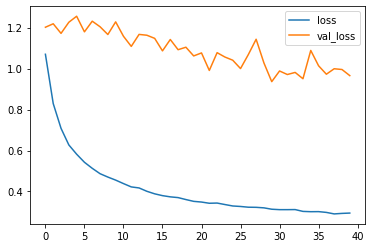

In [11]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [12]:
# ------------------ Testing on Aticks's data -----------------

y_true = val_y.ravel()
y_pred = np.argmax(model.predict(val_X), axis=1)

result_atick = classification_report(y_true, y_pred)
print(result_atick)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1349
           1       0.34      0.99      0.51       494
           2       0.55      0.14      0.22      1205

    accuracy                           0.60      3048
   macro avg       0.59      0.67      0.54      3048
weighted avg       0.67      0.60      0.56      3048



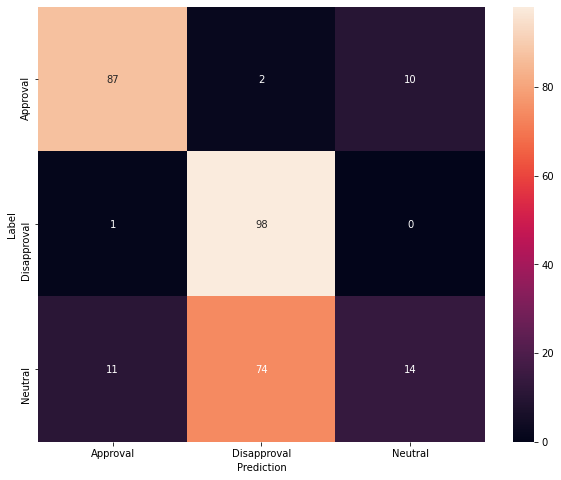

In [13]:
# confusion_mtx_atick = tf.math.confusion_matrix(y_true, y_pred) 
confusion_mtx_atick = (confusion_matrix(y_true, y_pred, normalize='true') * 100).astype('int')
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_atick, xticklabels=EMOTIONS, yticklabels=EMOTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [14]:
# ------------------ Testing on Valentina's data -----------------

y_true = test_y.ravel()
y_pred = np.argmax(model.predict(test_X), axis=1)

result_valentina = classification_report(y_true, y_pred)
print(result_valentina)

              precision    recall  f1-score   support

           0       0.68      0.37      0.48      1781
           1       0.06      0.07      0.06       377
           2       0.84      0.93      0.89      7326

    accuracy                           0.79      9484
   macro avg       0.53      0.46      0.48      9484
weighted avg       0.78      0.79      0.78      9484



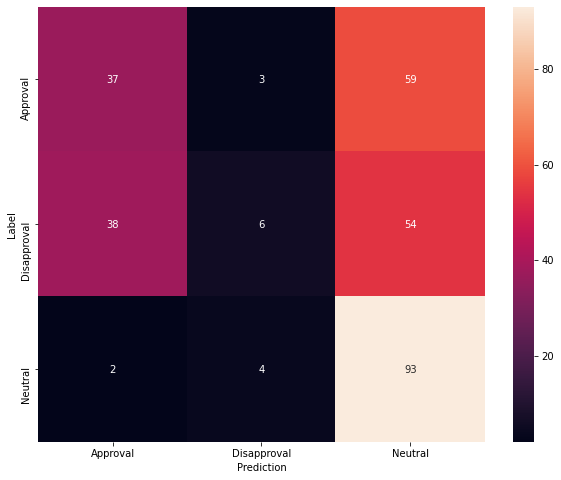

In [15]:
# confusion_mtx_valentina = tf.math.confusion_matrix(y_true, y_pred) 
confusion_mtx_valentina = (confusion_matrix(y_true, y_pred, normalize='true') * 100).astype('int')
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_valentina, xticklabels=EMOTIONS, yticklabels=EMOTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [16]:
summary = []
model.summary(print_fn=lambda x: summary.append(x))
CONFIG['architecture'] = summary
CONFIG['epochs'] = max(history.epoch)
CONFIG['training_time'] = training_time
CONFIG['testing_time'] = testing_time
CONFIG['cm_atick'] = np.array2string(confusion_mtx_atick)
result_list_atick = result_atick.split('\n')
CONFIG['cr_atick'] = result_list_atick
CONFIG['cm_valentina'] = np.array2string(confusion_mtx_valentina)
result_list_valentina = result_valentina.split('\n')
CONFIG['cr_valentina'] = result_list_valentina

In [17]:
config = json.dumps(CONFIG, indent=4)
print(config)

{
    "timestamp": "2021-05-18 18:18:53.419594",
    "model": "Transfer Learning on MobileNet",
    "base_model": "mobile_net_v2",
    "input_shape": [
        160,
        160,
        3
    ],
    "test_fold": "Fold 5",
    "frame_length": 44100,
    "frame_inc": 11025,
    "fig_size": [
        2.23,
        2.23
    ],
    "architecture": [
        "Model: \"model\"",
        "_________________________________________________________________",
        "Layer (type)                 Output Shape              Param #   ",
        "=================================================================",
        "input_2 (InputLayer)         [(None, 160, 160, 3)]     0         ",
        "_________________________________________________________________",
        "tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         ",
        "_________________________________________________________________",
        "tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         ",
        "

In [18]:
f = open(LOG_FILE, 'a')
f.write('\n')
f.write(config)
f.write('\n')
f.close()